In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

import time

import tfdiffeq
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

# tf.config.list_physical_devices('GPU')

device = 'cpu:0' 

#### load tclab measured data  

model 4.6 consists of 12 cycles and a 360s period of time  
switch with 20s delay, followed by 100s up and 240s down

In [2]:
name = "model.4.6"
fname = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name))

from _helpers import Helpers_

t,u,y,data_size = Helpers_.tfload_(fname)

print(f"load data '{name}' with size {data_size}")

load data 'model.4.6' with size 4320


#### import neural ode model

In [3]:
from _models import NeuralODE,SurrogateODE,HelperODE,ParamsODE

#### neural net training by batch

monitoring data results and loss per iteration with optimizer adam  
batch decision to get a calm loss behaviour

In [12]:
%%time

n_iters = 500       # iterations to train

batch_time = 10     # time scale to odeint
batch_due = 10       # due to reduce data size 
                    # to a batch size
batch_size = int((data_size-batch_time)/batch_due)

print_freq = 10     # freq to print sth out

data_monitor = []
loss_monitor = []

with tf.device(device):

    # build model
    model = NeuralODE()
    balan = SurrogateODE(params=ParamsODE())

    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr)

    itime = time.time()        

    # iterate
    print("iter | delay | loss")

    for itr in range(1,n_iters+1):
        
        with tf.GradientTape() as tape:

            # batch
            batch_y0, batch_t, batch_y,batch_i = HelperODE.batch_(t, y, batch_size=batch_size, batch_time=batch_time, data_size=data_size)

            # integrate to predict
            y_pred = tfdiffeq.odeint(model, batch_y0, batch_t, method="dopri5") 

            # energy balance surrogate
            y_bala = tfdiffeq.odeint(balan, batch_y0, batch_t)

            # compute loss
            loss = tf.reduce_mean(tf.square(y_bala - y_pred))

            data_monitor.append([batch_i,y_pred.numpy().flatten()])
            loss_monitor.append([loss.numpy()])
        
        # pack loss and trainable variables of the tf model
        gg = tape.gradient(loss, model.trainable_variables)
        gv = zip(gg, model.trainable_variables)       
        
        # optimzer setup to do sth against the loss
        optimizer.apply_gradients(gv) 

        if itr % print_freq == 0:            
            dtime = time.time()-itime
            print(f"{itr:04d} | {dtime:5.2f} | {loss.numpy():12.6f}")
            itime = time.time()


iter | delay | loss
0010 |  9.58 |  2506.833195
0020 |  9.93 |  2256.090734
0030 |  9.38 |  2015.188001
0040 |  9.71 |  1797.073586
0050 |  9.57 |  1595.927753
0060 |  9.36 |  1389.593476
0070 |  9.03 |  1207.663093
0080 |  9.48 |  1039.170630
0090 |  9.91 |   882.561813
0100 |  8.88 |   724.614739
0110 |  9.43 |   586.293822
0120 |  9.78 |   454.684569
0130 |  9.27 |   352.812465
0140 |  9.30 |   272.030462
0150 |  9.42 |   204.269466
0160 |  9.23 |   169.484715
0170 |  8.94 |   135.594241
0180 |  8.94 |   102.413660
0190 |  8.03 |    84.719653
0200 |  7.93 |    68.801089
0210 |  7.98 |    54.070330
0220 |  8.00 |    37.938012
0230 |  7.85 |    21.772170
0240 |  7.87 |    15.089629
0250 |  7.88 |    10.372530
0260 |  7.97 |     8.209017
0270 |  7.77 |     5.843877
0280 |  7.74 |     4.376260
0290 |  7.93 |     3.941402
0300 |  8.38 |     2.707714
0310 |  7.87 |     2.335418
0320 |  8.26 |     0.750796
0330 |  7.71 |     0.266526
0340 |  8.63 |     0.182542
0350 |  9.30 |     0.072550


#### save model of the neural ode model

In [13]:
model_name = os.path.join(os.getcwd(),"data","tclab.%s.pinn.tf"%(name))
model.save(model_name, save_format="tf")

INFO:tensorflow:Assets written to: c:\Develop\vsc\tclab\data\tclab.model.4.6.pinn.tf\assets


#### plot results over data set and loss

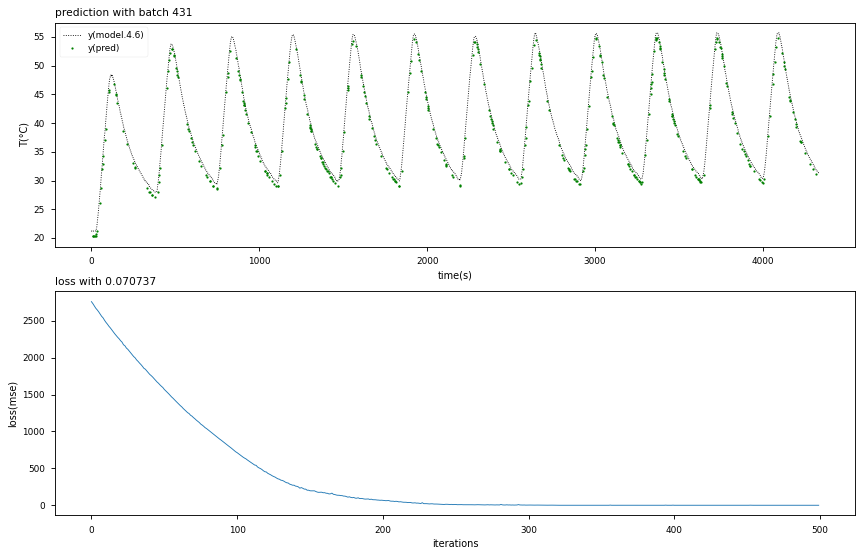

In [14]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80
plt.rcParams["lines.linewidth"] = .8

ncols,nrows = 1,2
nwidth,nheight = 16,4

fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
fig.subplots_adjust(right=0.75)

ts = t.numpy().flatten()
ys = y.numpy().flatten()

ax = axx[0]
ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

k = -1

# time by batched indizes
i_ = data_monitor[k][0]
t_ = ts[i_]

# batch slices in one chain
s_ = data_monitor[k][1]

# plot last batch only
i = 1
y_ = s_[-i*batch_size:len(s_)-(i-1)*batch_size]
ax.plot(t_,y_,'o',ms=2,label="y(pred)",color="green")

ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")

ax.legend()
ax.set_title("prediction with batch %d"%(batch_size),x=0,ha="left")

ax = axx[1]
lm = np.array(loss_monitor).flatten()
ax.plot(lm)

ax.set_xlabel("iterations"); ax.set_ylabel("loss(mse)")

ax.set_title("loss with %.6f"%(lm[-1]),x=0,ha="left")

plt.show()
plt.close()

#### plot surrogate and neural ode test results

the higher the batch due, the smaller the batch and the loss increases  
surrogate cannot make a better evaluation  
for test purposes only that the model is reconstructed correctly and to compare the surrogate  

In [17]:

def plot_test(ts,us,ys,
              yy,
              loss,
              indizes,
              size,
              name
              ):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,2
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    # model test

    ax = axx[0]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[0][-size:][a_]

    ax.plot(t_,y_,':o',ms=2,label="y(test)",color="green")

    ax.legend()
    ax.set_title("test with batch %d, loss %.6f"%(size, loss[0]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    # balance equivalence

    ax = axx[1]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[1][-size:][a_]

    ax.plot(t_,y_,':o',ms=2,label="y(surr)",color="red")

    ax.legend()
    ax.set_title("surrogate with batch %d, loss %.6f"%(size,loss[1]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    for ax in axx.ravel():
        ax.set_xlabel("time(s)")
        ax.set_ylabel("T(°C)")

    plt.show()
    plt.close()


#### load data of model.q.X  

test for convenience  
model contains random generated switching states

In [15]:
name2 = "model.q.3"
fname2 = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name2))

t2,u2,y2,data_size2 = Helpers_.tfload_(fname2)

print(f"load data '{name2}' with size {data_size2}")

load data 'model.q.3' with size 1200


In [16]:
%%time

batch_time_test2 = 5
batch_due_test2 = 1
batch_size_test2 = int((data_size2 - batch_time_test2)/batch_due_test2)

with tf.device(device):
    
    # reconstruct the trained neural ode
    model_name = os.path.join(os.getcwd(),"data","tclab.model.4.6.pinn.tf")
    recon = tf.keras.models.load_model(model_name, compile=False)
    
    batch_y02, batch_t2, batch_y2,batch_i2 = HelperODE.batch_(t2, y2, batch_size=batch_size_test2, batch_time=batch_time_test2, data_size=data_size2)
    
    y_test2 = tfdiffeq.odeint(recon, batch_y02, batch_t2, method="dopri5")
    l_test2 = tf.reduce_mean(tf.square(batch_y2 - y_test2))
    y_test2 = y_test2.numpy().flatten() 

    # energy balance surrogate
    balan = SurrogateODE(params=ParamsODE())

    y_bala2 = tfdiffeq.odeint(balan, batch_y02, batch_t2)
    l_bala2 = tf.reduce_mean(tf.square(batch_y2 - y_bala2))
    y_bala2 = y_bala2.numpy().flatten()

print(f"data size {data_size2}; batch time {batch_time_test2} due {batch_due_test2} size {batch_size_test2}")
print(f"loss test {l_test2:.6f} and surrogate {l_bala2:.6f}")

data size 1200; batch time 5 due 1 size 1195
loss test 0.047445 and surrogate 0.031055
CPU times: total: 359 ms
Wall time: 618 ms


#### plot q-test model result and surrogate test result  

surrogate is not as good as expected  
neural ode knows more about the instrinsic properties  

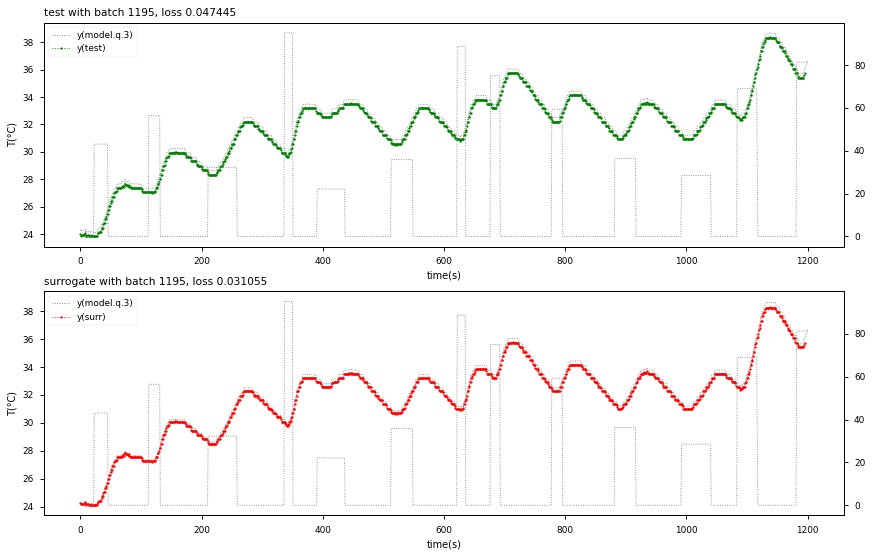

In [18]:
ts = t2.numpy().flatten()
us = u2.numpy().flatten()
ys = y2.numpy().flatten()


plot_test(ts,us,ys,
          yy=[y_test2,y_bala2],
          loss=[l_test2,l_bala2],
          indizes=batch_i2,
          size=batch_size_test2,
          name=name2
          )